<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Case-2:-Pneumonia-X-ray-image-analysis-(Model-2)" data-toc-modified-id="Case-2:-Pneumonia-X-ray-image-analysis"><span class="toc-item-num">1&nbsp;&nbsp;</span>Case 2: Pneumonia X-ray image analysis</a></span></li><li><span><a href="#Background" data-toc-modified-id="Background-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Background</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Models-and-training" data-toc-modified-id="Models-and-training-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Models and training</a></span></li><li><span><a href="#Results-and-Discussion" data-toc-modified-id="Results-and-Discussion-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Results and Discussion</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></div>

# Case 2: Pneumonia X-ray image analysis (Model 2)
Team 16:
1. Bellarina Chew
2. Nik Adam Nik Joharris
3. Valentin Dassin<br>

Last modified: 27.02.2020<br>
Neural Networks for Health Technology Applications
[Helsinki Metropolia University of Applied Sciences](http://www.metropolia.fi/en/)<br>

## Background
The aim of this notebook is to create and train a dense neural network to classify medical images accurately with convolutional neural network using the dataset from https://data.mendeley.com/datasets/rscbjbr9sj/2

## Data
The dataset used is a dataset of Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification from Mendeley Data

In [1]:
%pylab inline
import time 
import os
import shutil
import random
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Accuracy, FalseNegatives, FalsePositives
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
print('Tensorflow version = ', tf.__version__)

Populating the interactive namespace from numpy and matplotlib
Tensorflow version =  2.0.0


#### First, we initialize the training data

In [2]:
train_dir = "/Users/Adam/Desktop/Metropolia UAS/Neural Networks/Data/ChestXRay2017/chest_xray/train"

os.listdir(train_dir)

test_dir = "/Users/Adam/Desktop/Metropolia UAS/Neural Networks/Data/ChestXRay2017/chest_xray/test"

os.listdir(test_dir)

['.DS_Store', 'NORMAL', 'PNEUMONIA']

### Preprocess data
#### Scaling
All images were rescaled to 1./255, this is to ensure that training is faster. In addition, the images have also been resized to 150x150 pixels. Other data augmentation techniques are also explored i.e. rotation range, width shift, height shift, etc. to help solve overfitting issues and help enhance the model's generalization abilities. 
#### Split data
The training and validation set is split into 70% and 30% respectively.

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.3
    )

#### Create data generators:

In [4]:
# Training data generator
print('Training:')
train_generator = train_datagen.flow_from_directory(
    # This is the target directory
    train_dir, 
    
    # All images will be resizd to 200x200
    target_size=(150, 150),
    
    # We read the images in batches
    batch_size=16,

    # Create binary labels
    class_mode='binary',

    # This will be the training set
    subset="training")

# Validation data generator
print('\nValidation:')
valid_generator = train_datagen.flow_from_directory(
    # This is the target directory
    train_dir, 
    
    # All images will be resizd to 200x200
    target_size=(150, 150),
    
    # We read the images in batches
    batch_size=16,

    # Create binary labels
    class_mode='binary',

    # This will be the validation set
    subset="validation",

    #shuffle has to be false
    shuffle = False)

test_datagen = ImageDataGenerator(rescale=1./255)

# Create the same thing for validation set
test_generator = test_datagen.flow_from_directory(
    # This is the target directory
    test_dir, 
    
    # All images will be resizd to 200x200
    target_size=(150, 150),
    
    # We read the images in batches
    batch_size=16,

    # Create binary labels
    class_mode='binary',

    #shuffle has to be false
    shuffle = False)

Training:
Found 3664 images belonging to 2 classes.

Validation:
Found 1568 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


#### Now, tests have to be taken place to see if the generator works. 
The function label_batch place labels automatically for whichecer folder come first alphabetically i.e. normal = 0, pnuemonia = 1.

In [5]:
i = 0
for data_batch, labels_batch in train_generator:
    print('data batch shape: ', data_batch.shape)
    print('labels batch shape: ', labels_batch.shape)
    i = i+1
    if i > 5:
        break

data batch shape:  (16, 150, 150, 3)
labels batch shape:  (16,)
data batch shape:  (16, 150, 150, 3)
labels batch shape:  (16,)
data batch shape:  (16, 150, 150, 3)
labels batch shape:  (16,)
data batch shape:  (16, 150, 150, 3)
labels batch shape:  (16,)
data batch shape:  (16, 150, 150, 3)
labels batch shape:  (16,)
data batch shape:  (16, 150, 150, 3)
labels batch shape:  (16,)


Upon checking the first image from the batch, the image has now been resized to 150x150 pixels

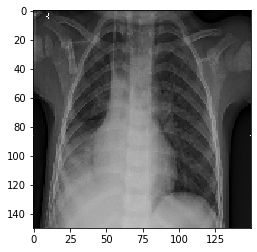

In [6]:
#check the first image from the batch 
#notice that the image has been now resized to 150x150 pixels
imshow(data_batch[0])
show()

## Model and training
The model below shows an example of a proposed Convolutional Neural Network (CNN) model, inspired from Stephen et al.(2019)[1]. Their model consist of two major parts: the classifier and (sigmoid activation function) and the feature extractors.The proposed architecture includes he convolution, max-pooling, and classification layers combined together. The feature extractors comprise conv3 × 3, 32; conv3 × 3, 64; conv3 × 3, 128; conv3 × 3, 128, max-pooling layer of size 2 × 2, and a RELU activator between them. The output of the convolution and max-pooling operations are assembled into 2D planes called feature maps, and we obtained 198 × 198 × 32, 97 × 97 × 62, 46 × 64× 128, and 21 × 21 × 128 sizes of feature maps, respectively, for the convolution operations and 99 × 99 × 32, 48 × 48 × 64, 23 × 23 × 128, and 10 × 10 × 128 sizes of feature maps from the pooling operations, respectively, with an input of image of size 200 × 200 × 3 as shown in Table 2.

In [7]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

### Compile the model:

The metrics used for this assignment are accuracy, false negatives, and false positives. After several iterations, the RMSprop optimizer was chosen because it produce the best results compared.

In [8]:
# Use different set of metrics 
my_metrics = ['acc', FalseNegatives(), FalsePositives()]

# Compile the model
model.compile(loss = 'binary_crossentropy',
             optimizer = optimizers.RMSprop(lr = 1e-4),
             metrics = my_metrics)

### Train the model:

In [9]:
# Start the clock
t_start = time.time()

print('Training...', end='')
h = model.fit_generator(
    train_generator,
    steps_per_epoch=None,
    verbose=0,
    epochs=4,
    validation_data=valid_generator,
    validation_steps=None)

#save the model
model.save('case2_run_1.h5')

# Cehcl the time and calculate the elapsed time and time per epoch
t_end = time.time()
t_elapsed = t_end - t_start
t_per_epoch = t_elapsed/3

print('Done')
print(f'Time elapsed = {t_elapsed:.0f} seconds')
print(f'Time per epoch = {t_per_epoch:.2f} seconds')

Training...Done
Time elapsed = 1394 seconds
Time per epoch = 464.53 seconds


In [10]:
hh = h.history
acc = hh['acc']
acc_v = hh['val_acc']
fn = hh['false_negatives']
fn_v = hh['val_false_negatives']
fp = hh['false_positives']
fp_v = hh['val_false_positives']
loss = hh['loss']
loss_v = hh['val_loss']
epochs = arange(len(loss)) + 1

show()

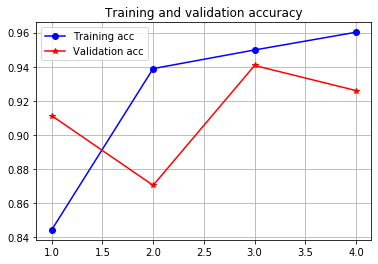

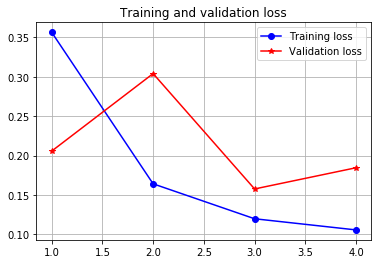

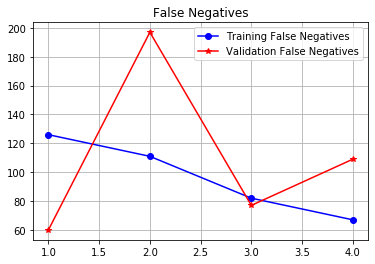

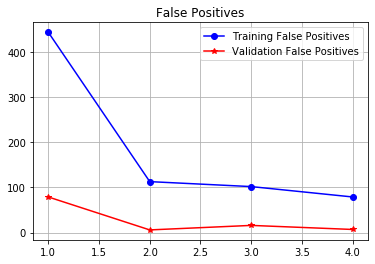

In [11]:
plot(epochs, acc, 'bo-', label='Training acc')
plot(epochs, acc_v, 'r*-', label='Validation acc')
title('Training and validation accuracy')
grid()
legend()

figure()
plot(epochs, loss, 'bo-', label='Training loss')
plot(epochs, loss_v, 'r*-', label='Validation loss')
title('Training and validation loss')
legend()
grid()

figure()
plot(epochs, fn, 'bo-', label='Training False Negatives')
plot(epochs, fn_v, 'r*-', label='Validation False Negatives')
title('False Negatives')
legend()
grid()

figure()
plot(epochs, fp, 'bo-', label='Training False Positives')
plot(epochs, fp_v, 'r*-', label='Validation False Positives')
title('False Positives')
legend()

grid()
show()

From the graph above, the model's accuracy almost peaked at 96% before it started to overfit. The value of the training loss is decent as well, averaging 0.15 before starts to overfit. 

## Evaluate the model

When the model was evaluated, first the confusion matrix was produced to evaluate the performance of the model. The classification report was then generated to observe how well the model was able to predict pneumonia. Results show that specificty is 98% and sensitivity is 91% when a threshold of 0.5 was used. However, this threshold was not optimum and a new threshold was used later after determining the opmtimum value. This will be shown later 

In [12]:
labels = valid_generator.classes

predicted = model.predict_generator(valid_generator).flatten()

cm = confusion_matrix(labels, predicted > 0.5)
print(cm)

[[ 397    7]
 [ 109 1055]]


In [13]:
# Calculate classification report 
cr = classification_report(labels, predicted > 0.5, target_names=['Normal (0)', 'Pneumonia (1)'])
print(cr)

               precision    recall  f1-score   support

   Normal (0)       0.78      0.98      0.87       404
Pneumonia (1)       0.99      0.91      0.95      1164

     accuracy                           0.93      1568
    macro avg       0.89      0.94      0.91      1568
 weighted avg       0.94      0.93      0.93      1568



In [14]:
#ROC curve analysis
fpr, tpr, thresholds = roc_curve(labels, predicted, pos_label = 1)

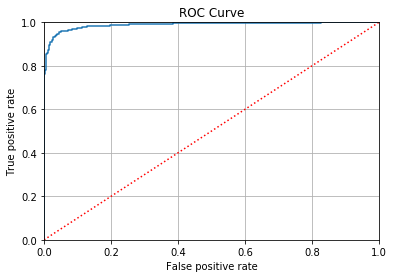

In [15]:
plot(fpr, tpr)
plot([0,1], [0,1], 'r:')
xlabel('False positive rate')
ylabel('True positive rate')
title('ROC Curve')
xlim([0,1])
ylim([0,1])
grid()

As shown above, the ROC curve shows that the model is predicting the images at a really good rate. The graph shows a high area under curve (AUC) value, which means it has good measure of separability. 

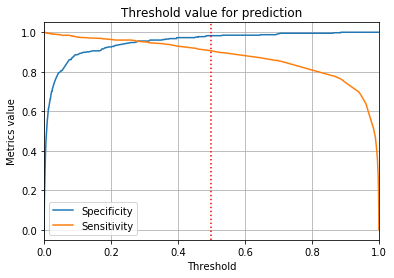

In [16]:
#Find the threshold
plot(thresholds, 1 - fpr, label = 'Specificity')
plot(thresholds, tpr, label = 'Sensitivity')
axvline(0.5, color = 'red', linestyle=':')
xlim([0,1])
title('Threshold value for prediction')
xlabel('Threshold')
ylabel('Metrics value')
legend()
grid()

The specificty and sensitivity distribution curve is of the is plotted to see which threshold would produce the best results. As shown above, the two curves intersect at 0.2, hence that is the optimum value. After adjusting the threshold to 0.2, the sensitivity improved. Although there were some values that were negatively affected, this was compensated with more accurate results.

In [17]:
theshold = 0.2
cr = classification_report(labels, predicted > theshold, target_names=['Normal (0)', 'Pneumonia (1)'])
print(cr)

               precision    recall  f1-score   support

   Normal (0)       0.90      0.93      0.91       404
Pneumonia (1)       0.97      0.96      0.97      1164

     accuracy                           0.95      1568
    macro avg       0.94      0.94      0.94      1568
 weighted avg       0.95      0.95      0.95      1568



In [19]:
# compute the confusion matrix and use it to derive the raw accuracy, sensitivity, and specificity
cm = confusion_matrix(labels, predicted>0.2)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("\naccuracy: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[ 374   30]
 [  43 1121]]

accuracy: 0.9534
sensitivity: 0.9257
specificity: 0.9631


# Conclusion

After several iterations and tests to the model, this was the best outcome for me. The accuracy was approaximately 96%, sensitivity and specificty were both 93% and 96% respectively after choosing the optimum threshold. Although the numbers were pretty decent in the model, the time taken to run was simply too long, and I believe with more time to trial and error, better results can be produced in the near future.

# Reference

1. Stephen, Okeke, Sain, Mangal, Maduh, Joseph, U., & Jeong. (2019, March 27). An Efficient Deep Learning Approach to Pneumonia Classification in Healthcare. Retrieved March 1, 2020, from https://www.hindawi.com/journals/jhe/2019/4180949/